In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import time

import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from model import BaselineModel_linear as BaselineModel

sns.set()
sns.color_palette("bright")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


In [3]:
seed = 42 
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

full_trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

batch_size = 100

num_train = len(full_trainset)
num_valid = int(0.1 * num_train)
num_train -= num_valid

trainset, validset = random_split(full_trainset, [num_train, num_valid])

# Create the DataLoader for training and validation sets
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

# Download and load the test dataset
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
net = BaselineModel(3, 32, 32)
net.to(device)

BaselineModel_linear(
  (fc1): Linear(in_features=3072, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
num_epochs = 30
training_losses = []
validation_losses = []

for epoch in range(num_epochs): 
    start = time.time()
    net.train()
    training_loss = 0.0
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
    training_loss /= len(trainloader)
    training_losses.append(training_loss)

    # Validation
    net.eval()
    validation_loss = 0
    with torch.no_grad(): 
        for (inputs, labels) in validloader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
    
    validation_loss /= len(validloader)
    validation_losses.append(validation_loss)

    end = time.time()
    
    print(f"Epoch: {epoch+1}, training_loss: {training_loss}, validation_loss: {validation_loss}, time: {end-start:.2f}")    

Epoch: 1, training_loss: 1.772069174978468, validation_loss: 1.7659909582138063, time: 38.09
Epoch: 2, training_loss: 1.7440282450781928, validation_loss: 1.7527365326881408, time: 36.95
Epoch: 3, training_loss: 1.7249942673577203, validation_loss: 1.7448213839530944, time: 37.07
Epoch: 4, training_loss: 1.7136776985062494, validation_loss: 1.738380742073059, time: 36.41
Epoch: 5, training_loss: 1.702656921810574, validation_loss: 1.738036904335022, time: 37.55
Epoch: 6, training_loss: 1.6949371136559381, validation_loss: 1.7284742569923401, time: 36.57
Epoch: 7, training_loss: 1.6883386188083225, validation_loss: 1.727040979862213, time: 38.03
Epoch: 8, training_loss: 1.6821096155378554, validation_loss: 1.7227913284301757, time: 40.09
Epoch: 9, training_loss: 1.6778645708825852, validation_loss: 1.7224009108543397, time: 37.66
Epoch: 10, training_loss: 1.673162484963735, validation_loss: 1.719599690437317, time: 37.29


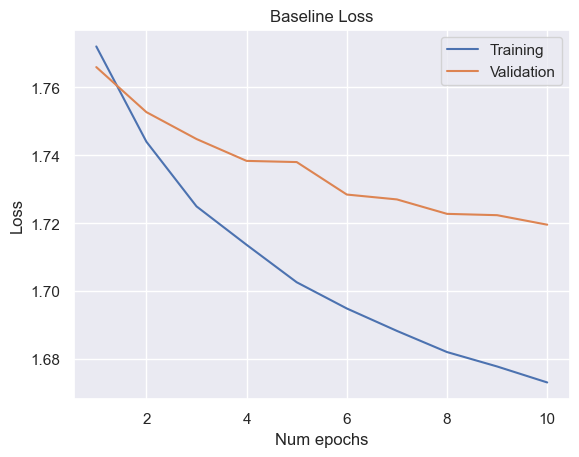

In [10]:
x = np.linspace(1, len(training_losses), len(training_losses))
plt.plot(x, training_losses, label="Training")
plt.plot(x, validation_losses, label="Validation")
plt.xlabel("Num epochs")
plt.ylabel("Loss")
plt.title("Baseline Loss")
plt.legend()

plt.show()

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for (images, labels) in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 41 %
